In [2]:
#import packages 
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.sparse import linalg as sla
%matplotlib inline
import sys
sys.path.insert(0, '/Users/Deehrlich/Desktop/BootCamp2017/Econ/Wk3_FirmDyn/Code')
import ar1_approx as ar1
from scipy.optimize import brentq

In [3]:
""" Problem 1 """

' Problem 1 '

In [4]:
# specify parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
z = 1
betafirm = (1 / (1 + r))
sigma_eps = 0.213
mu = 0
rho = 0.7605
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))
sizez = 9

In [5]:
#Kgird
dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

In [6]:
#Markov Process, Use DeBacker's Code
z_grid, pi = ar1.addacooper(sizez, mu, rho, sigma_eps)
z_grid = np.exp(z_grid)

In [7]:
# Operating profits, op
op = np.zeros((sizek, sizez))
for i in range(sizez):
    op[:,i] = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) * (z_grid[i] ** \
            (1 / (1 - alpha_l)))*((kvec ** alpha_k) ** (1 / (1 - alpha_l))))

# Firm cash flow, e
e = np.zeros((sizek, sizek, sizez))
for i in range(sizek):
    for j in range(sizek):
        for k in range(sizez):
            e[i,j,k] = (op[i,k] - kvec[j] + ((1 - delta) * kvec[i]) - ((psi / 2) * ((kvec[j] - ((1 - delta) * \
                        kvec[i])) ** 2) / kvec[i]))

In [8]:
#Value Function Itteration 

VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((sizek, sizez))  # initial guess at value function
Vmat = np.zeros((sizek, sizek, sizez))  # initialize Vmat matrix
Vstore = np.zeros((sizek,sizez, VFmaxiter))  # initialize Vstore array
VFiter = 1


start_time = time.clock()
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for k in range(sizez): # loop over z
                Vmat[i, j, k] = e[i, j, k] + betafirm * V[j, :]@pi[:, k]
                
    V = Vmat.max(axis=1)  # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')

VF = V  # solution to the functional equation

Value function converged after this many iterations: 366
VFI took  42.342866  seconds to solve


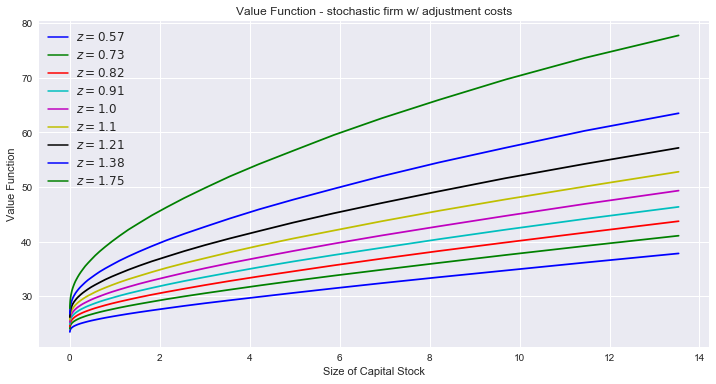

In [8]:
#Plot Value Function

fig ,ax =  plt.subplots(figsize=(12, 6))
for i in range(sizez):
    plt.plot(kvec, V[:,i],'k', label='$z = {i}$'.format(i=round(z_grid[i], 2)), color='bgrcmykbg'[i])
    
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
# Now add the legend with some customizations.
legend = ax.legend(loc='best', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.title('Value Function - stochastic firm w/ adjustment costs')

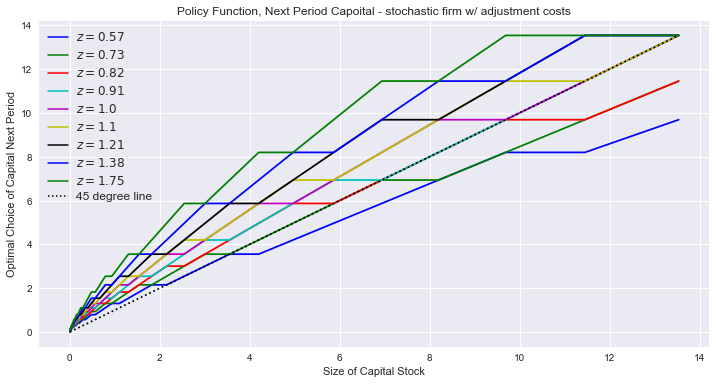

In [9]:
# Plot optimal capital stock rule as a function of firm size
optK = kvec[PF]
fig ,ax =  plt.subplots(figsize=(12, 6))

for i in range(sizez):
    plt.plot(kvec, optK[:,i],'k', label='$z = {i}$'.format(i=round(z_grid[i], 2)), color='bgrcmykbg'[i])

ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='best', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - stochastic firm w/ ' +
          'adjustment costs')

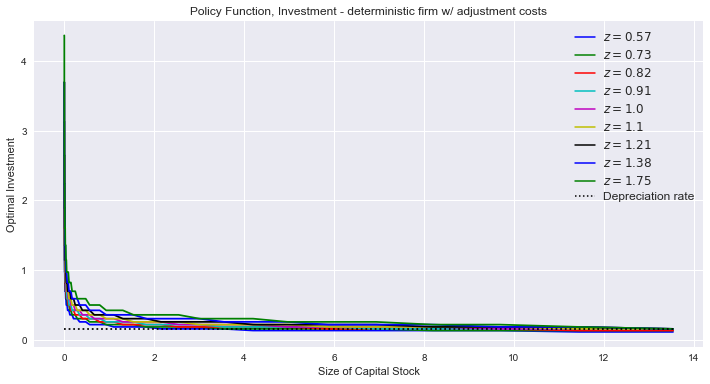

In [10]:
# Plot investment rule as a function of firm size
optI = optK - (1 - delta) * optK
fig ,ax =  plt.subplots(figsize=(12, 6))

for i in range(sizez):
    plt.plot(kvec, optI[:,i]/kvec,'k', label='$z = {i}$'.format(i=round(z_grid[i], 2)), color='bgrcmykbg'[i])

ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='best', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Investment')
plt.title('Policy Function, Investment - deterministic firm w/ adjustment ' +
          'costs')

In [11]:
""" Problem 2 """

' Problem 2 '

In [12]:
psic = 0.03 #psi cost

In [13]:
# Operating profits, op, haven't changed
# Firm cash flow, e, cost function changed if choose to invest
e = np.zeros((sizek, sizek, sizez))
for i in range(sizek):
    for j in range(sizek):
        for k in range(sizez):
            e[i,j,k] = (op[i,k] - kvec[j] + ((1 - delta) * kvec[i]) - (psic * kvec[i]))


In [14]:
#Value Function Itteration 

VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((sizek, sizez))  # initial guess at value function
Vmat = np.zeros((sizek, sizek, sizez))
Vmat1 = np.zeros((sizek, sizek, sizez))
Vmat2 = np.zeros((sizek,sizez))
VFiter = 1


start_time = time.clock()
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for k in range(sizez): # loop over z
                Vmat1[i,j,k] = e[i,j,k] + betafirm * V[j,:]@pi[k,:]
                if i == 0:
                    Vmat2[i,k] = op[i,k] + betafirm * V[i,:]@pi[k,:]
                    Vmat[i,j,k] = max(Vmat2[i,k],Vmat1[i,j,k])
                else:
                    Vmat2[i,k] = op[i,k] + betafirm * V[i-1,:]@pi[k,:]
                    Vmat[i,j,k] = max(Vmat2[i,k],Vmat1[i,j,k])
    
    
    V = Vmat.max(axis=1)
    PF = np.argmax(Vmat, axis=1)  
    VFdist = (np.absolute(V - TV)).max()
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')

VF = V 

Value function converged after this many iterations: 368
VFI took  92.02551  seconds to solve


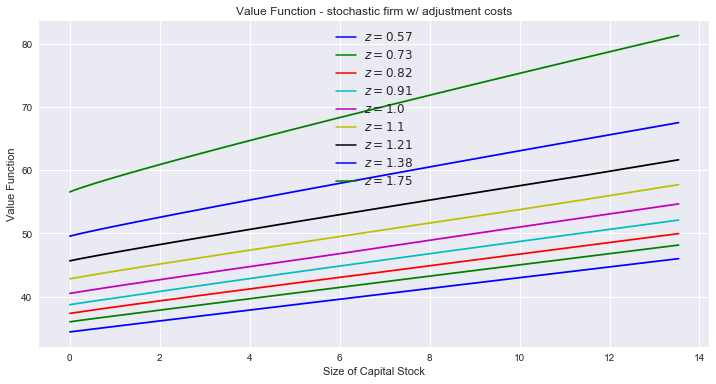

In [15]:
#Plot Value Function

fig ,ax =  plt.subplots(figsize=(12, 6))
for i in range(sizez):
    plt.plot(kvec, V[:,i],'k', label='$z = {i}$'.format(i=round(z_grid[i], 2)), color='bgrcmykbg'[i])
    
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
# Now add the legend with some customizations.
legend = ax.legend(loc='best', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.title('Value Function - stochastic firm w/ adjustment costs')

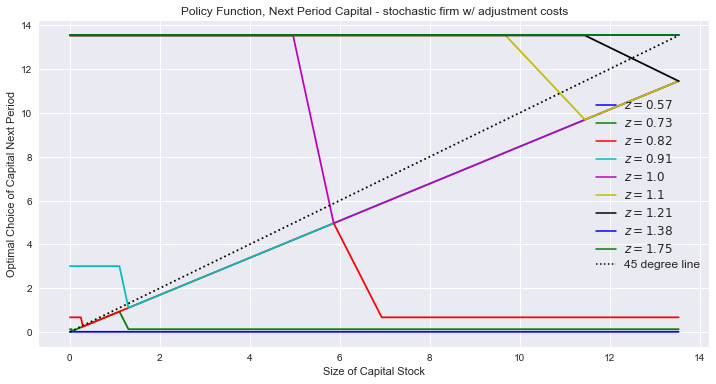

In [25]:
# Plot optimal capital stock rule as a function of firm size
invbool = Vmat1.max(axis=1) > Vmat2 #boolean for whether or not to invest
for i in range(sizek):
    for k in range(sizez):
        if invbool[i,k] == False:
            if i != 0:
                PF[i, k] = i - 1
            else:
                PF[i, k] = i 
                
optK = kvec[PF]
fig ,ax =  plt.subplots(figsize=(12, 6))

for i in range(sizez):
    plt.plot(kvec, optK[:,i],'k', label='$z = {i}$'.format(i=round(z_grid[i], 2)), color='bgrcmykbg'[i])

ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='best', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capital - stochastic firm w/ ' +
            'adjustment costs')

In [17]:
""" Problem 3 """

' Problem 3 '

In [18]:
def pi2(k,z):
    result = alpha_k * ((alpha_l / w)) ** (alpha_l / (1 - alpha_l)) * z ** (1 / (1 - alpha_l)) * \
           k ** ((alpha_k + alpha_l - 1)/(1 - alpha_l))
    return result

def c1(k1, k):
    result = (psi*(k1-(1-delta)*k)/k)
    return result

def c2(k1, k):
    result  = (psi / 2) * (2*(k1-(1-delta)*k)*(delta-1)*k-(k1-(1-delta)*k)**2)/(k**2)
    return result

In [19]:
#parameters
iternum = 1
tol = 1e-6
dist = 7.0
maxiter = 3000

#initialize arrays
Kold = np.zeros((sizez, sizek))

def Coleman_itteration(Knew):
    Knew = Kold.copy()
    for i in range(sizez):
        g_func = lambda x: np.interp(x, kvec, Kold[i, :])
        for j in range(sizek):           
            def h(k1): #using Stachurski's Code 
                vals = pi2(k1, z_grid) @ pi[i, :]
                """ The previous version of this code used to run, but I didnt 
                get the chance to both clean up the code and to test it. This 
                code will not run because shapes and indices have not yet aligned"""
                return 1 + c1(k1, kvec[j]) - (betafirm * (vals + (1 - delta) - c2(g_func(k1), k1)))            
            k_star = brentq(h, 1e-10, 1e3)
            Knew[i, j] = k_star
    return Knew

start_time = time.clock()
while dist > tol and iternum < maxiter:
    Knew =  Coleman_itteration(Kold)      
    dist = (np.absolute(Knew - Kold)).max()
    Kold = Knew.copy()
    iternum += 1

CP_time = time.clock() - start_time 
if iternum < maxiter:
    print('Policy function converged after this many iterations:', iternum)
else:
    print('Policy function did not converge')
print('Coleman Policy Iteration took ', CP_time, ' seconds to solve')

Policy function converged after this many iterations: 29
Coleman Policy Iteration took  24.648683000000005  seconds to solve


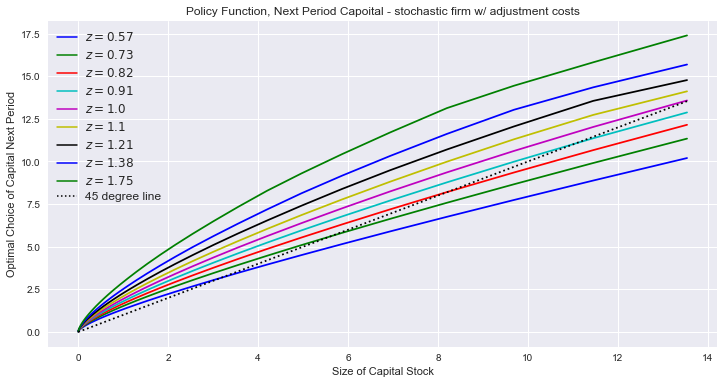

In [20]:
#Plot Policy Functions
fig ,ax =  plt.subplots(figsize=(12, 6))
for i in range(sizez):
    plt.plot(kvec, Knew[i,:],'k', label='$z = {i}$'.format(i=round(z_grid[i], 2)), color='bgrcmykbg'[i])

plt.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = plt.legend(loc='best', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - stochastic firm w/ ' +
          'adjustment costs')

In [10]:
""" This graph doesn't perfectly correspond to the graph of the Policy functions on problem 1, but this may
be due to the coarseness of the grid. This could also be due to this graph being wrong. The latter is 
probably true but I wasn't able to entirely figure that out. """

" This graph doesn't perfectly correspond to the graph of the Policy functions on problem 1, but this may\nbe due to the coarseness of the grid. This could also be due to this graph being wrong. The latter is \nprobably true but I wasn't able to entirely figure that out. "